In [1]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
import importlib.util

# Define the path to the .py file
file_path = "/kaggle/input/new-dataloader-prep/dataloader_prep_1.py"

# Load the module
spec = importlib.util.spec_from_file_location("dataloader_prep_1", file_path)
dataloader_prep = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dataloader_prep)

# Now, you can use functions from the script


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Load the dataset
file_path = "/kaggle/input/cyberbullying-tweets-dataset/cyberbullying_tweets.csv"
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [6]:
X = df['tweet_text']
y = df['cyberbullying_type']
print(len(X))

47692


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = seed_value)

# Get unique class counts
class_counts = np.column_stack(np.unique(y_train, return_counts=True))
class_counts

array([['age', 6394],
       ['ethnicity', 6369],
       ['gender', 6378],
       ['not_cyberbullying', 6356],
       ['other_cyberbullying', 6258],
       ['religion', 6398]], dtype=object)

In [8]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler()

# Resample the dataset
X_resampled, y_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))

# Convert resampled data into a DataFrame
train_os = pd.DataFrame({'text_clean': X_resampled.ravel(), 'sentiment': y_resampled.ravel()})

# Extract resampled values
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

# Get unique class counts
class_counts = np.column_stack(np.unique(y_train, return_counts=True))
class_counts


array([['age', 6398],
       ['ethnicity', 6398],
       ['gender', 6398],
       ['not_cyberbullying', 6398],
       ['other_cyberbullying', 6398],
       ['religion', 6398]], dtype=object)

In [9]:
from collections import Counter

def Vocab(column):
    vocab = [] # Initialize an empty list to store words
    
    # Iterate over each text entry in the column
    for text in column:
        for word in text.split():
            vocab.append(word)
        
    counter = Counter(vocab)
    sorted_words = counter.most_common()
            
    vocab_id = []
    for i, tup in enumerate(sorted_words):
        word, freq = tup
        vocab_id.append((word, i))

    return vocab_id

vocab = Vocab(df["tweet_text"])

In [10]:
Word2Vec_train_data = [text.split() for text in X_train]


In [11]:
train_loader, test_loader, train_dataset, test_dataset, num_labels, label_mapping = dataloader_prep.prepare_dataloader("/kaggle/input/cyberbullying-tweets-dataset/cyberbullying_tweets.csv")

Label mapping: {'not_cyberbullying': 0, 'gender': 1, 'religion': 2, 'other_cyberbullying': 3, 'age': 4, 'ethnicity': 5}
Label distribution:
 label
2    7998
4    7992
1    7973
5    7961
0    7945
3    7823
Name: count, dtype: int64
Dataset Loaded
                                           tweet_text cyberbullying_type  label
0  In other words #katandandre, your food was cra...  not_cyberbullying      0
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying      0
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying      0
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying      0
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying      0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
print(label_mapping)
print(num_labels)

{'not_cyberbullying': 0, 'gender': 1, 'religion': 2, 'other_cyberbullying': 3, 'age': 4, 'ethnicity': 5}
6


In [13]:
len(train_dataset.labels)

42922

In [14]:
from torch.utils.data import random_split, DataLoader

print(len(train_dataset))
print(len(test_dataset))
# Define split ratio (e.g., 80% train, 20% validation)
train_ratio = 0.8
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size  # Remaining for validation

# Split dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create new DataLoaders
train_loader = DataLoader(train_subset, batch_size=train_loader.batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=train_loader.batch_size, shuffle=False)

print(type(train_loader.dataset))
print(type(val_loader))
print(f"Original validation subset size: {len(val_subset)}")
print(f"Original train subset size: {len(train_subset)}")

print(len(train_subset))
print(len(val_subset))

42922
4770
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataloader.DataLoader'>
Original validation subset size: 8585
Original train subset size: 34337
34337
8585


In [15]:
# Attention mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        factor = 2 if is_bidirectional else 1
        self.attn = nn.Linear(hidden_dim * factor, hidden_dim * factor)
        self.v = nn.Linear(hidden_dim * factor, 1, bias=False)

    def forward(self, lstm_output):
        attn_scores = self.v(torch.tanh(self.attn(lstm_output)))  # (batch_size, seq_len, 1)
        attn_weights = F.softmax(attn_scores, dim=1)  # (batch_size, seq_len, 1)
        context = torch.bmm(attn_weights.transpose(1, 2), lstm_output).squeeze(1)  # (batch_size, hidden_dim * num_directions)
        return context



In [16]:
class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        factor = 2 if is_bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional, dropout=dropout)
        self.attention = Attention(hidden_dim, is_bidirectional)
        self.fc = nn.Linear(hidden_dim * factor, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_length, hidden_dim * num_directions)
        context = self.attention(lstm_out)  # (batch_size, hidden_dim * num_directions)
        output = self.softmax(self.fc(context))  # (batch_size, num_classes)
        return output


In [17]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = num_labels
VOCAB_SIZE = len(vocab)+1

In [18]:
from tqdm import tqdm
import copy

# Training and Validation
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, patience=10):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float("inf")
    patience_counter = 0
    best_model = copy.deepcopy(model)  # Save best model

    for epoch in range(epochs):
        # Training Phase
        model.train()
        epoch_loss, correct, total = 0, 0, 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]") as pbar:
            for batch in pbar:
                inputs = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)

                optimizer.zero_grad()
                output = model(inputs)  # Fix: Only passing `inputs`
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                y_pred_train = torch.argmax(output, dim=1)
                correct += torch.sum(y_pred_train == labels).item()
                total += labels.size(0)

                pbar.set_postfix({
                    "Loss": f"{loss.item():.4f}",
                    "Acc": f"{100 * correct / total:.3f}%"
                })

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = 100 * correct / total
        train_accuracies.append(train_acc)

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]") as pbar:
                for batch in pbar:
                    inputs = batch["input_ids"].to(device)
                    labels = batch["labels"].to(device)

                    output = model(inputs)
                    loss = criterion(output, labels)
                    val_loss += loss.item()

                    y_pred_val = torch.argmax(output, dim=1)
                    val_correct += torch.sum(y_pred_val == labels).item()
                    val_total += labels.size(0)

                    pbar.set_postfix({"Loss": f"{loss.item():.4f}","Acc": f"{100 * val_correct / val_total:.3f}%"})

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * val_correct / val_total
        val_accuracies.append(val_acc)

        # Print epoch summary
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.2f}% Validation Loss   = {avg_val_loss:.4f}, Validation Acc   = {val_acc:.2f}%")

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model)  
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Early stopping patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping...No improvement in Validation Loss!")
            break

    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

In [19]:
from torch.utils.data import Subset
reduced_train_size = int(0.3*len(train_subset))
reduced_val_size = int(0.3*len(val_subset))

train_indices = list(range(len(train_subset)))
val_indices = list(range(len(val_subset)))

reduced_train_indices = train_indices[:reduced_train_size]
reduced_val_indices = val_indices[:reduced_val_size]

reduced_train_dataset = Subset(train_subset, reduced_train_indices)
reduced_val_dataset = Subset(val_subset, reduced_val_indices)

reduced_train_loader = DataLoader(reduced_train_dataset, batch_size = 32, shuffle=True)
reduced_val_loader = DataLoader(reduced_val_dataset, batch_size=32, shuffle = False)

print(len(val_subset))
print(len(reduced_val_dataset))



8585
2575


In [20]:
import optuna
import itertools
from torch.utils.data import DataLoader

tried_configs = set()

# Objective function for tuning
def objective(trial):
    embedding_dim = trial.suggest_categorical("embedding_dim", [200, 300])
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256])
    is_bidirectional = trial.suggest_categorical("is_bidirectional", [True, False])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-3)
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.3, 0.5])
    lstm_layers = trial.suggest_categorical("lstm_layers",[2,3])
    
    # Hyperparameter combination
    config = (embedding_dim, hidden_dim, is_bidirectional, lr, dropout_rate, lstm_layers)

    # Check if this combination was already tried
    if config in tried_configs:
        print(f"Skipping already tried configuration: {config}")
        raise optuna.TrialPruned()  # Prune this trial early

    # Add new config to the set
    tried_configs.add(config)
    
    model = LSTM_Sentiment_Classifier(
        vocab_size=VOCAB_SIZE,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_classes=NUM_CLASSES,
        lstm_layers=lstm_layers,
        dropout=dropout_rate,
        is_bidirectional=is_bidirectional
    ).to(DEVICE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    print(f"\nTrial {trial.number}: Embedding_Dim: {embedding_dim}, Hidden_Dim: {hidden_dim}, Is Bidirectional: {is_bidirectional}, Learning Rate: {lr}, LSTM Layers: {lstm_layers}, Dropout Rate: {dropout_rate}")

    best_model, train_losses, val_losses, train_accuracies, val_accuracies = train(
        model, reduced_train_loader, reduced_val_loader, criterion, optimizer, epochs=3, device=DEVICE
    )

    best_val_loss = val_losses[0]
    for val_loss in val_losses:
        if val_loss<best_val_loss:
            best_val_loss = val_loss
    return best_val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=70)

print("Best Params:", study.best_params)


[I 2025-03-31 13:11:09,274] A new study created in memory with name: no-name-0b77d4b1-ec82-41d0-9a89-235581b4ae71
<ipython-input-20-db74c927c736>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-3)



Trial 0: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.00016066133026556312, LSTM Layers: 3, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 201.04it/s, Loss=0.4943, Acc=61.398%]


Epoch 1: Train Loss = 1.4184, Train Acc = 36.86% Validation Loss   = 0.8720, Validation Acc   = 61.40%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 208.64it/s, Loss=0.4236, Acc=67.417%]


Epoch 2: Train Loss = 0.7961, Train Acc = 63.56% Validation Loss   = 0.7306, Validation Acc   = 67.42%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 206.98it/s, Loss=0.4591, Acc=72.505%]
[I 2025-03-31 13:11:24,114] Trial 0 finished with value: 0.6188207743344484 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.00016066133026556312, 'dropout_rate': 0.5, 'lstm_layers': 3}. Best is trial 0 with value: 0.6188207743344484.


Epoch 3: Train Loss = 0.6684, Train Acc = 70.14% Validation Loss   = 0.6188, Validation Acc   = 72.50%

Trial 1: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.000205073294241531, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 205.10it/s, Loss=0.7976, Acc=62.136%]


Epoch 1: Train Loss = 1.4507, Train Acc = 36.01% Validation Loss   = 0.9388, Validation Acc   = 62.14%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 208.86it/s, Loss=0.6663, Acc=74.447%]


Epoch 2: Train Loss = 0.7008, Train Acc = 69.05% Validation Loss   = 0.5648, Validation Acc   = 74.45%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 210.10it/s, Loss=0.5783, Acc=74.796%]
[I 2025-03-31 13:11:37,881] Trial 1 finished with value: 0.5303100196667659 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.000205073294241531, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 1 with value: 0.5303100196667659.


Epoch 3: Train Loss = 0.5145, Train Acc = 76.18% Validation Loss   = 0.5303, Validation Acc   = 74.80%

Trial 2: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0009815593443308949, LSTM Layers: 3, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 199.64it/s, Loss=0.4362, Acc=74.718%]


Epoch 1: Train Loss = 0.8818, Train Acc = 62.56% Validation Loss   = 0.5624, Validation Acc   = 74.72%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 200.85it/s, Loss=0.3790, Acc=78.641%]


Epoch 2: Train Loss = 0.4744, Train Acc = 77.61% Validation Loss   = 0.4734, Validation Acc   = 78.64%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 207.17it/s, Loss=0.3360, Acc=79.417%]
[I 2025-03-31 13:11:53,981] Trial 2 finished with value: 0.4734060486525665 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0009815593443308949, 'dropout_rate': 0.5, 'lstm_layers': 3}. Best is trial 2 with value: 0.4734060486525665.


Epoch 3: Train Loss = 0.3924, Train Acc = 81.86% Validation Loss   = 0.4756, Validation Acc   = 79.42%
Early stopping patience: 1/10

Trial 3: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0007801918293228621, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 233.00it/s, Loss=0.3956, Acc=77.282%]


Epoch 1: Train Loss = 0.8694, Train Acc = 63.01% Validation Loss   = 0.5000, Validation Acc   = 77.28%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 235.41it/s, Loss=0.3855, Acc=80.155%]


Epoch 2: Train Loss = 0.4474, Train Acc = 79.59% Validation Loss   = 0.4648, Validation Acc   = 80.16%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 233.79it/s, Loss=0.3547, Acc=80.893%]
[I 2025-03-31 13:12:08,249] Trial 3 finished with value: 0.45426184509271456 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0007801918293228621, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 3 with value: 0.45426184509271456.


Epoch 3: Train Loss = 0.3561, Train Acc = 84.75% Validation Loss   = 0.4543, Validation Acc   = 80.89%

Trial 4: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005916846361122726, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.39it/s, Loss=0.3447, Acc=76.660%]


Epoch 1: Train Loss = 0.7668, Train Acc = 66.55% Validation Loss   = 0.5066, Validation Acc   = 76.66%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.75it/s, Loss=0.3922, Acc=80.893%]


Epoch 2: Train Loss = 0.4331, Train Acc = 80.47% Validation Loss   = 0.4407, Validation Acc   = 80.89%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.95it/s, Loss=0.3566, Acc=81.592%]
[I 2025-03-31 13:12:30,561] Trial 4 finished with value: 0.44072346610051616 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005916846361122726, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 4 with value: 0.44072346610051616.


Epoch 3: Train Loss = 0.3400, Train Acc = 85.44% Validation Loss   = 0.4644, Validation Acc   = 81.59%
Early stopping patience: 1/10

Trial 5: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.00012619154906634295, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.60it/s, Loss=0.5478, Acc=76.777%]


Epoch 1: Train Loss = 0.9705, Train Acc = 60.97% Validation Loss   = 0.5249, Validation Acc   = 76.78%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.33it/s, Loss=0.3749, Acc=79.340%]


Epoch 2: Train Loss = 0.4788, Train Acc = 79.80% Validation Loss   = 0.4689, Validation Acc   = 79.34%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.70it/s, Loss=0.4163, Acc=79.223%]
[I 2025-03-31 13:13:11,684] Trial 5 finished with value: 0.4654432410075341 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.00012619154906634295, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 4 with value: 0.44072346610051616.


Epoch 3: Train Loss = 0.3965, Train Acc = 83.37% Validation Loss   = 0.4654, Validation Acc   = 79.22%

Trial 6: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00044553872679752124, LSTM Layers: 3, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 137.45it/s, Loss=0.3139, Acc=77.359%]


Epoch 1: Train Loss = 0.8666, Train Acc = 63.01% Validation Loss   = 0.4908, Validation Acc   = 77.36%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.99it/s, Loss=0.3993, Acc=79.340%]


Epoch 2: Train Loss = 0.4503, Train Acc = 79.46% Validation Loss   = 0.4970, Validation Acc   = 79.34%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.61it/s, Loss=0.3050, Acc=80.544%]
[I 2025-03-31 13:13:34,007] Trial 6 finished with value: 0.4908461798856288 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00044553872679752124, 'dropout_rate': 0.5, 'lstm_layers': 3}. Best is trial 4 with value: 0.44072346610051616.


Epoch 3: Train Loss = 0.3516, Train Acc = 85.01% Validation Loss   = 0.5013, Validation Acc   = 80.54%
Early stopping patience: 2/10

Trial 7: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0004401786874829169, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.32it/s, Loss=0.3506, Acc=78.602%]


Epoch 1: Train Loss = 0.8234, Train Acc = 65.15% Validation Loss   = 0.4689, Validation Acc   = 78.60%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 166.06it/s, Loss=0.3503, Acc=79.922%]


Epoch 2: Train Loss = 0.4165, Train Acc = 82.12% Validation Loss   = 0.4511, Validation Acc   = 79.92%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 169.75it/s, Loss=0.4392, Acc=81.825%]
[I 2025-03-31 13:13:52,514] Trial 7 finished with value: 0.4455889266582183 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0004401786874829169, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 4 with value: 0.44072346610051616.


Epoch 3: Train Loss = 0.3368, Train Acc = 85.74% Validation Loss   = 0.4456, Validation Acc   = 81.83%

Trial 8: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006462020959678608, LSTM Layers: 3, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.94it/s, Loss=0.3985, Acc=77.398%]


Epoch 1: Train Loss = 0.7972, Train Acc = 64.94% Validation Loss   = 0.4860, Validation Acc   = 77.40%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.83it/s, Loss=0.2713, Acc=80.544%]


Epoch 2: Train Loss = 0.4371, Train Acc = 80.14% Validation Loss   = 0.4404, Validation Acc   = 80.54%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.76it/s, Loss=0.3566, Acc=80.699%]
[I 2025-03-31 13:14:14,765] Trial 8 finished with value: 0.44042978444953024 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006462020959678608, 'dropout_rate': 0.5, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3481, Train Acc = 85.14% Validation Loss   = 0.4746, Validation Acc   = 80.70%
Early stopping patience: 1/10

Trial 9: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00024024334440651997, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.50it/s, Loss=0.7011, Acc=72.505%]


Epoch 1: Train Loss = 1.0790, Train Acc = 53.59% Validation Loss   = 0.5880, Validation Acc   = 72.50%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 142.69it/s, Loss=0.6344, Acc=77.204%]


Epoch 2: Train Loss = 0.5222, Train Acc = 76.06% Validation Loss   = 0.5009, Validation Acc   = 77.20%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.87it/s, Loss=0.5520, Acc=79.728%]
[I 2025-03-31 13:14:34,743] Trial 9 finished with value: 0.4876800576845805 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00024024334440651997, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.4319, Train Acc = 80.11% Validation Loss   = 0.4877, Validation Acc   = 79.73%

Trial 10: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.0003119524374107404, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 78.08it/s, Loss=0.4280, Acc=75.845%]


Epoch 1: Train Loss = 0.8637, Train Acc = 63.37% Validation Loss   = 0.5080, Validation Acc   = 75.84%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 78.57it/s, Loss=0.2965, Acc=79.146%]


Epoch 2: Train Loss = 0.4689, Train Acc = 79.37% Validation Loss   = 0.4695, Validation Acc   = 79.15%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 78.79it/s, Loss=0.4728, Acc=79.845%]
[I 2025-03-31 13:15:13,223] Trial 10 finished with value: 0.46381562304349594 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.0003119524374107404, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3818, Train Acc = 83.69% Validation Loss   = 0.4638, Validation Acc   = 79.84%

Trial 11: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.000555519571011893, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 50.12it/s, Loss=0.4400, Acc=79.184%]


Epoch 1: Train Loss = 0.7209, Train Acc = 69.19% Validation Loss   = 0.4859, Validation Acc   = 79.18%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 50.95it/s, Loss=0.3637, Acc=80.233%]


Epoch 2: Train Loss = 0.4379, Train Acc = 81.21% Validation Loss   = 0.4516, Validation Acc   = 80.23%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.32it/s, Loss=0.3778, Acc=80.505%]
[I 2025-03-31 13:16:13,883] Trial 11 finished with value: 0.45162150300579307 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.000555519571011893, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3551, Train Acc = 85.19% Validation Loss   = 0.4794, Validation Acc   = 80.50%
Early stopping patience: 1/10

Trial 12: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006851400855284486, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 141.74it/s, Loss=0.4322, Acc=78.369%]


Epoch 1: Train Loss = 0.7742, Train Acc = 67.12% Validation Loss   = 0.4770, Validation Acc   = 78.37%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.77it/s, Loss=0.5598, Acc=79.301%]


Epoch 2: Train Loss = 0.4152, Train Acc = 82.65% Validation Loss   = 0.4731, Validation Acc   = 79.30%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.83it/s, Loss=0.4550, Acc=80.388%]
[I 2025-03-31 13:16:36,235] Trial 12 finished with value: 0.47309587583129786 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006851400855284486, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3278, Train Acc = 86.85% Validation Loss   = 0.4824, Validation Acc   = 80.39%
Early stopping patience: 1/10

Trial 13: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0004217003404456888, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.38it/s, Loss=0.3008, Acc=76.621%]


Epoch 1: Train Loss = 0.8581, Train Acc = 62.64% Validation Loss   = 0.4856, Validation Acc   = 76.62%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.26it/s, Loss=0.4951, Acc=78.757%]


Epoch 2: Train Loss = 0.4421, Train Acc = 79.01% Validation Loss   = 0.4920, Validation Acc   = 78.76%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.70it/s, Loss=0.2131, Acc=80.699%]
[I 2025-03-31 13:16:58,606] Trial 13 finished with value: 0.45398595101303524 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0004217003404456888, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3473, Train Acc = 84.46% Validation Loss   = 0.4540, Validation Acc   = 80.70%

Trial 14: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.0005893130798975572, LSTM Layers: 3, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 49.65it/s, Loss=0.3233, Acc=77.476%]


Epoch 1: Train Loss = 0.7595, Train Acc = 67.56% Validation Loss   = 0.4726, Validation Acc   = 77.48%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 50.23it/s, Loss=0.4529, Acc=80.233%]


Epoch 2: Train Loss = 0.4568, Train Acc = 79.68% Validation Loss   = 0.4543, Validation Acc   = 80.23%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 48.92it/s, Loss=0.6897, Acc=79.845%]
[I 2025-03-31 13:17:59,119] Trial 14 finished with value: 0.4543256402751546 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.0005893130798975572, 'dropout_rate': 0.5, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3686, Train Acc = 83.93% Validation Loss   = 0.4816, Validation Acc   = 79.84%
Early stopping patience: 1/10

Trial 15: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0009719877626150746, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.74it/s, Loss=0.4015, Acc=78.019%]


Epoch 1: Train Loss = 0.7217, Train Acc = 68.54% Validation Loss   = 0.4810, Validation Acc   = 78.02%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.48it/s, Loss=0.5273, Acc=79.845%]


Epoch 2: Train Loss = 0.4163, Train Acc = 81.29% Validation Loss   = 0.4678, Validation Acc   = 79.84%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.85it/s, Loss=0.3912, Acc=81.786%]
[I 2025-03-31 13:18:21,522] Trial 15 finished with value: 0.46777676229859577 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0009719877626150746, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3291, Train Acc = 86.43% Validation Loss   = 0.4778, Validation Acc   = 81.79%
Early stopping patience: 1/10

Trial 16: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0003325972534767375, LSTM Layers: 3, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 136.91it/s, Loss=0.5661, Acc=76.660%]


Epoch 1: Train Loss = 0.8895, Train Acc = 61.96% Validation Loss   = 0.5211, Validation Acc   = 76.66%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.36it/s, Loss=0.4127, Acc=79.650%]


Epoch 2: Train Loss = 0.4539, Train Acc = 79.11% Validation Loss   = 0.4567, Validation Acc   = 79.65%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.68it/s, Loss=0.4514, Acc=80.078%]
[I 2025-03-31 13:18:43,925] Trial 16 finished with value: 0.45672746407396997 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0003325972534767375, 'dropout_rate': 0.5, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3712, Train Acc = 83.52% Validation Loss   = 0.4897, Validation Acc   = 80.08%
Early stopping patience: 1/10

Trial 17: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006968431425277265, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.97it/s, Loss=0.3683, Acc=78.718%]


Epoch 1: Train Loss = 0.7577, Train Acc = 67.17% Validation Loss   = 0.4741, Validation Acc   = 78.72%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.52it/s, Loss=0.5090, Acc=79.961%]


Epoch 2: Train Loss = 0.4245, Train Acc = 81.27% Validation Loss   = 0.4606, Validation Acc   = 79.96%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.95it/s, Loss=0.6577, Acc=81.476%]
[I 2025-03-31 13:19:06,335] Trial 17 finished with value: 0.4606276233623057 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006968431425277265, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3164, Train Acc = 86.94% Validation Loss   = 0.4834, Validation Acc   = 81.48%
Early stopping patience: 1/10

Trial 18: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: False, Learning Rate: 0.0005413356538841568, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 129.37it/s, Loss=0.3393, Acc=75.767%]


Epoch 1: Train Loss = 0.8953, Train Acc = 61.18% Validation Loss   = 0.5393, Validation Acc   = 75.77%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 127.51it/s, Loss=0.3801, Acc=78.913%]


Epoch 2: Train Loss = 0.4896, Train Acc = 77.62% Validation Loss   = 0.4948, Validation Acc   = 78.91%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 130.40it/s, Loss=0.3145, Acc=79.728%]
[I 2025-03-31 13:19:30,075] Trial 18 finished with value: 0.49017162289884353 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': False, 'lr': 0.0005413356538841568, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.4125, Train Acc = 82.33% Validation Loss   = 0.4902, Validation Acc   = 79.73%

Trial 19: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00034777750330120466, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.55it/s, Loss=0.4336, Acc=77.204%]


Epoch 1: Train Loss = 0.8924, Train Acc = 61.60% Validation Loss   = 0.4901, Validation Acc   = 77.20%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.04it/s, Loss=0.4059, Acc=79.417%]


Epoch 2: Train Loss = 0.4492, Train Acc = 80.43% Validation Loss   = 0.4631, Validation Acc   = 79.42%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 142.47it/s, Loss=0.3442, Acc=80.621%]
[I 2025-03-31 13:19:52,464] Trial 19 finished with value: 0.46313217907776066 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00034777750330120466, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3643, Train Acc = 84.11% Validation Loss   = 0.4667, Validation Acc   = 80.62%
Early stopping patience: 1/10

Trial 20: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0008249915019709368, LSTM Layers: 3, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 142.57it/s, Loss=0.4984, Acc=76.777%]


Epoch 1: Train Loss = 0.7623, Train Acc = 65.93% Validation Loss   = 0.4999, Validation Acc   = 76.78%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.35it/s, Loss=0.6040, Acc=79.573%]


Epoch 2: Train Loss = 0.4364, Train Acc = 79.92% Validation Loss   = 0.4772, Validation Acc   = 79.57%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.80it/s, Loss=0.5713, Acc=80.660%]
[I 2025-03-31 13:20:14,863] Trial 20 finished with value: 0.46832824452423755 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0008249915019709368, 'dropout_rate': 0.3, 'lstm_layers': 3}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3452, Train Acc = 85.11% Validation Loss   = 0.4683, Validation Acc   = 80.66%

Trial 21: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0004452513528102565, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.50it/s, Loss=0.4111, Acc=79.650%]


Epoch 1: Train Loss = 0.8052, Train Acc = 66.36% Validation Loss   = 0.4733, Validation Acc   = 79.65%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.98it/s, Loss=0.6107, Acc=81.010%]


Epoch 2: Train Loss = 0.4164, Train Acc = 82.48% Validation Loss   = 0.4532, Validation Acc   = 81.01%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.77it/s, Loss=0.7496, Acc=81.049%]
[I 2025-03-31 13:20:33,388] Trial 21 finished with value: 0.4532037890619702 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0004452513528102565, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 8 with value: 0.44042978444953024.


Epoch 3: Train Loss = 0.3169, Train Acc = 86.99% Validation Loss   = 0.4667, Validation Acc   = 81.05%
Early stopping patience: 1/10

Trial 22: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005088638245033547, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.96it/s, Loss=0.3588, Acc=80.738%]


Epoch 1: Train Loss = 0.7979, Train Acc = 68.34% Validation Loss   = 0.4447, Validation Acc   = 80.74%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.24it/s, Loss=0.4231, Acc=82.058%]


Epoch 2: Train Loss = 0.4070, Train Acc = 83.23% Validation Loss   = 0.4204, Validation Acc   = 82.06%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.66it/s, Loss=0.8216, Acc=81.049%]
[I 2025-03-31 13:20:51,981] Trial 22 finished with value: 0.4203503242245427 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005088638245033547, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3134, Train Acc = 87.09% Validation Loss   = 0.4510, Validation Acc   = 81.05%
Early stopping patience: 1/10

Trial 23: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005697742154625984, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.20it/s, Loss=0.4419, Acc=80.078%]


Epoch 1: Train Loss = 0.7605, Train Acc = 68.46% Validation Loss   = 0.4580, Validation Acc   = 80.08%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.75it/s, Loss=0.2709, Acc=81.165%]


Epoch 2: Train Loss = 0.4021, Train Acc = 82.55% Validation Loss   = 0.4458, Validation Acc   = 81.17%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.97it/s, Loss=0.3071, Acc=81.553%]
[I 2025-03-31 13:21:10,557] Trial 23 finished with value: 0.4395539050484881 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005697742154625984, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3067, Train Acc = 87.10% Validation Loss   = 0.4396, Validation Acc   = 81.55%

Trial 24: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006827443205702558, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.04it/s, Loss=0.4162, Acc=79.146%]


Epoch 1: Train Loss = 0.7218, Train Acc = 70.01% Validation Loss   = 0.4693, Validation Acc   = 79.15%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.17it/s, Loss=0.3709, Acc=80.583%]


Epoch 2: Train Loss = 0.3828, Train Acc = 83.81% Validation Loss   = 0.4626, Validation Acc   = 80.58%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.35it/s, Loss=0.3954, Acc=80.350%]
[I 2025-03-31 13:21:29,079] Trial 24 finished with value: 0.46264394749829796 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006827443205702558, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2801, Train Acc = 88.97% Validation Loss   = 0.4888, Validation Acc   = 80.35%
Early stopping patience: 1/10

Trial 25: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.000262146158177483, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.45it/s, Loss=0.4333, Acc=76.660%]


Epoch 1: Train Loss = 0.9516, Train Acc = 60.44% Validation Loss   = 0.5094, Validation Acc   = 76.66%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.59it/s, Loss=0.3316, Acc=79.767%]


Epoch 2: Train Loss = 0.4557, Train Acc = 79.66% Validation Loss   = 0.4607, Validation Acc   = 79.77%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.62it/s, Loss=0.3582, Acc=80.311%]
[I 2025-03-31 13:21:47,738] Trial 25 finished with value: 0.4502849096869245 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.000262146158177483, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3792, Train Acc = 83.12% Validation Loss   = 0.4503, Validation Acc   = 80.31%

Trial 26: Embedding_Dim: 200, Hidden_Dim: 256, Is Bidirectional: False, Learning Rate: 0.00048169859881954714, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 130.59it/s, Loss=0.6038, Acc=75.689%]


Epoch 1: Train Loss = 0.8762, Train Acc = 63.27% Validation Loss   = 0.5349, Validation Acc   = 75.69%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 125.68it/s, Loss=0.3317, Acc=79.146%]


Epoch 2: Train Loss = 0.4990, Train Acc = 78.52% Validation Loss   = 0.5193, Validation Acc   = 79.15%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 125.01it/s, Loss=0.4448, Acc=80.000%]
[I 2025-03-31 13:22:11,365] Trial 26 finished with value: 0.47790572543938953 and parameters: {'embedding_dim': 200, 'hidden_dim': 256, 'is_bidirectional': False, 'lr': 0.00048169859881954714, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.4169, Train Acc = 82.60% Validation Loss   = 0.4779, Validation Acc   = 80.00%

Trial 27: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0003541628028663592, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.11it/s, Loss=0.5166, Acc=78.757%]


Epoch 1: Train Loss = 0.8489, Train Acc = 65.41% Validation Loss   = 0.4746, Validation Acc   = 78.76%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.95it/s, Loss=0.4292, Acc=80.078%]


Epoch 2: Train Loss = 0.4312, Train Acc = 81.53% Validation Loss   = 0.4455, Validation Acc   = 80.08%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.29it/s, Loss=0.5208, Acc=79.767%]
[I 2025-03-31 13:22:29,916] Trial 27 finished with value: 0.44551366769973144 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0003541628028663592, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3393, Train Acc = 85.41% Validation Loss   = 0.4645, Validation Acc   = 79.77%
Early stopping patience: 1/10

Trial 28: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.000800029109974043, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.03it/s, Loss=0.3675, Acc=80.932%]


Epoch 1: Train Loss = 0.6848, Train Acc = 71.76% Validation Loss   = 0.4394, Validation Acc   = 80.93%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 165.38it/s, Loss=0.3202, Acc=81.165%]


Epoch 2: Train Loss = 0.3926, Train Acc = 83.48% Validation Loss   = 0.4398, Validation Acc   = 81.17%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.98it/s, Loss=0.1772, Acc=83.107%]
[I 2025-03-31 13:22:48,485] Trial 28 finished with value: 0.43942422741725123 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.000800029109974043, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2902, Train Acc = 87.98% Validation Loss   = 0.4618, Validation Acc   = 83.11%
Early stopping patience: 2/10

Trial 29: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0007937364869631809, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 238.80it/s, Loss=0.5086, Acc=75.612%]


Epoch 1: Train Loss = 0.8595, Train Acc = 63.83% Validation Loss   = 0.5249, Validation Acc   = 75.61%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 241.73it/s, Loss=0.6820, Acc=78.175%]


Epoch 2: Train Loss = 0.4741, Train Acc = 78.67% Validation Loss   = 0.4920, Validation Acc   = 78.17%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 233.19it/s, Loss=0.6117, Acc=79.029%]
[I 2025-03-31 13:23:00,676] Trial 29 finished with value: 0.48616125995730175 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0007937364869631809, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3965, Train Acc = 82.23% Validation Loss   = 0.4862, Validation Acc   = 79.03%

Trial 30: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00010446853613965989, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.40it/s, Loss=0.6726, Acc=70.485%]


Epoch 1: Train Loss = 1.3723, Train Acc = 46.91% Validation Loss   = 0.6947, Validation Acc   = 70.49%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.47it/s, Loss=0.6823, Acc=75.029%]


Epoch 2: Train Loss = 0.5712, Train Acc = 74.89% Validation Loss   = 0.5255, Validation Acc   = 75.03%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 168.14it/s, Loss=0.5003, Acc=78.874%]
[I 2025-03-31 13:23:19,236] Trial 30 finished with value: 0.48805523893715425 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00010446853613965989, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.4617, Train Acc = 78.95% Validation Loss   = 0.4881, Validation Acc   = 78.87%

Trial 31: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0008875710112716654, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.27it/s, Loss=0.3151, Acc=80.621%]


Epoch 1: Train Loss = 0.6880, Train Acc = 71.53% Validation Loss   = 0.4407, Validation Acc   = 80.62%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.23it/s, Loss=0.2072, Acc=80.427%]


Epoch 2: Train Loss = 0.3890, Train Acc = 83.34% Validation Loss   = 0.4413, Validation Acc   = 80.43%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.11it/s, Loss=0.2515, Acc=80.660%]
[I 2025-03-31 13:23:37,746] Trial 31 finished with value: 0.4407082869682783 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0008875710112716654, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2951, Train Acc = 87.69% Validation Loss   = 0.4781, Validation Acc   = 80.66%
Early stopping patience: 2/10

Trial 32: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006601111051600104, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.65it/s, Loss=0.4046, Acc=79.650%]


Epoch 1: Train Loss = 0.7499, Train Acc = 68.73% Validation Loss   = 0.4683, Validation Acc   = 79.65%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.48it/s, Loss=0.4844, Acc=80.505%]


Epoch 2: Train Loss = 0.3934, Train Acc = 82.89% Validation Loss   = 0.4519, Validation Acc   = 80.50%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.22it/s, Loss=0.6630, Acc=79.806%]
[I 2025-03-31 13:23:56,313] Trial 32 finished with value: 0.4519293322975253 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006601111051600104, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2991, Train Acc = 87.93% Validation Loss   = 0.4952, Validation Acc   = 79.81%
Early stopping patience: 1/10

Trial 33: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005248953441155275, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.11it/s, Loss=0.3967, Acc=78.175%]


Epoch 1: Train Loss = 0.7680, Train Acc = 67.96% Validation Loss   = 0.4810, Validation Acc   = 78.17%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.96it/s, Loss=0.2777, Acc=80.466%]


Epoch 2: Train Loss = 0.4084, Train Acc = 82.02% Validation Loss   = 0.4533, Validation Acc   = 80.47%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.15it/s, Loss=0.3475, Acc=81.010%]
[I 2025-03-31 13:24:14,814] Trial 33 finished with value: 0.45171638624167737 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005248953441155275, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3263, Train Acc = 86.47% Validation Loss   = 0.4517, Validation Acc   = 81.01%

Trial 34: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0007702649060163767, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 241.11it/s, Loss=0.3592, Acc=76.583%]


Epoch 1: Train Loss = 0.8279, Train Acc = 64.92% Validation Loss   = 0.5079, Validation Acc   = 76.58%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 236.13it/s, Loss=0.3011, Acc=79.068%]


Epoch 2: Train Loss = 0.4439, Train Acc = 79.80% Validation Loss   = 0.4763, Validation Acc   = 79.07%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 218.82it/s, Loss=0.4210, Acc=79.845%]
[I 2025-03-31 13:24:29,201] Trial 34 finished with value: 0.47630143643897255 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0007702649060163767, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3503, Train Acc = 85.14% Validation Loss   = 0.4954, Validation Acc   = 79.84%
Early stopping patience: 1/10

Trial 35: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00017791417296374014, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.67it/s, Loss=0.4412, Acc=75.340%]


Epoch 1: Train Loss = 1.0740, Train Acc = 57.40% Validation Loss   = 0.5265, Validation Acc   = 75.34%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.52it/s, Loss=0.3006, Acc=78.175%]


Epoch 2: Train Loss = 0.4893, Train Acc = 77.11% Validation Loss   = 0.4691, Validation Acc   = 78.17%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.46it/s, Loss=0.2847, Acc=80.777%]
[I 2025-03-31 13:24:47,779] Trial 35 finished with value: 0.44849266498177137 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00017791417296374014, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.4008, Train Acc = 81.89% Validation Loss   = 0.4485, Validation Acc   = 80.78%

Trial 36: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0003885733724660944, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 234.53it/s, Loss=0.4939, Acc=68.233%]


Epoch 1: Train Loss = 1.1422, Train Acc = 49.33% Validation Loss   = 0.7267, Validation Acc   = 68.23%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 234.48it/s, Loss=0.3966, Acc=76.039%]


Epoch 2: Train Loss = 0.6184, Train Acc = 72.09% Validation Loss   = 0.5227, Validation Acc   = 76.04%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 233.77it/s, Loss=0.4339, Acc=78.835%]
[I 2025-03-31 13:25:00,023] Trial 36 finished with value: 0.4766758812798394 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0003885733724660944, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.4585, Train Acc = 78.80% Validation Loss   = 0.4767, Validation Acc   = 78.83%

Trial 37: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006135880245168149, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.54it/s, Loss=0.5541, Acc=79.612%]


Epoch 1: Train Loss = 0.7556, Train Acc = 69.17% Validation Loss   = 0.4659, Validation Acc   = 79.61%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.05it/s, Loss=0.4571, Acc=81.126%]


Epoch 2: Train Loss = 0.4067, Train Acc = 82.71% Validation Loss   = 0.4290, Validation Acc   = 81.13%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.29it/s, Loss=0.3679, Acc=81.476%]
[I 2025-03-31 13:25:18,547] Trial 37 finished with value: 0.4289966497892215 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006135880245168149, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3166, Train Acc = 86.70% Validation Loss   = 0.4484, Validation Acc   = 81.48%
Early stopping patience: 1/10

Trial 38: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.00048813525013587637, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.40it/s, Loss=0.3460, Acc=79.301%]


Epoch 1: Train Loss = 0.8104, Train Acc = 66.27% Validation Loss   = 0.4698, Validation Acc   = 79.30%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 168.99it/s, Loss=0.2205, Acc=80.621%]


Epoch 2: Train Loss = 0.4187, Train Acc = 81.96% Validation Loss   = 0.4444, Validation Acc   = 80.62%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.08it/s, Loss=0.2435, Acc=80.971%]
[I 2025-03-31 13:25:37,123] Trial 38 finished with value: 0.44444869826605293 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.00048813525013587637, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3221, Train Acc = 86.63% Validation Loss   = 0.4599, Validation Acc   = 80.97%
Early stopping patience: 1/10

Trial 39: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.0009886755057875187, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.09it/s, Loss=0.3548, Acc=80.233%]


Epoch 1: Train Loss = 0.6506, Train Acc = 73.72% Validation Loss   = 0.4797, Validation Acc   = 80.23%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 76.94it/s, Loss=0.5634, Acc=79.456%]


Epoch 2: Train Loss = 0.4074, Train Acc = 82.94% Validation Loss   = 0.4872, Validation Acc   = 79.46%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.37it/s, Loss=0.6018, Acc=81.049%]
[I 2025-03-31 13:26:18,237] Trial 39 finished with value: 0.47759387485774946 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.0009886755057875187, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3104, Train Acc = 87.64% Validation Loss   = 0.4776, Validation Acc   = 81.05%

Trial 40: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0006139994876011892, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 238.11it/s, Loss=0.3814, Acc=77.165%]


Epoch 1: Train Loss = 0.9573, Train Acc = 58.02% Validation Loss   = 0.5208, Validation Acc   = 77.17%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 236.06it/s, Loss=0.3634, Acc=79.417%]


Epoch 2: Train Loss = 0.4711, Train Acc = 79.80% Validation Loss   = 0.4806, Validation Acc   = 79.42%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 232.46it/s, Loss=0.4682, Acc=79.845%]
[I 2025-03-31 13:26:32,613] Trial 40 finished with value: 0.4764610672438586 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0006139994876011892, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3805, Train Acc = 84.04% Validation Loss   = 0.4765, Validation Acc   = 79.84%

Trial 41: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007405533735965563, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.06it/s, Loss=0.3112, Acc=79.223%]


Epoch 1: Train Loss = 0.7408, Train Acc = 67.46% Validation Loss   = 0.4750, Validation Acc   = 79.22%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.33it/s, Loss=0.2996, Acc=81.010%]


Epoch 2: Train Loss = 0.3995, Train Acc = 82.51% Validation Loss   = 0.4383, Validation Acc   = 81.01%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.65it/s, Loss=0.3545, Acc=81.243%]
[I 2025-03-31 13:26:51,142] Trial 41 finished with value: 0.438310052877591 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007405533735965563, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3024, Train Acc = 87.35% Validation Loss   = 0.4724, Validation Acc   = 81.24%
Early stopping patience: 1/10

Trial 42: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007522661661203466, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 166.64it/s, Loss=0.4247, Acc=78.835%]


Epoch 1: Train Loss = 0.7110, Train Acc = 70.69% Validation Loss   = 0.4769, Validation Acc   = 78.83%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.65it/s, Loss=0.4703, Acc=80.466%]


Epoch 2: Train Loss = 0.3889, Train Acc = 83.72% Validation Loss   = 0.4686, Validation Acc   = 80.47%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.10it/s, Loss=0.2305, Acc=80.388%]
[I 2025-03-31 13:27:09,730] Trial 42 finished with value: 0.4686322926003256 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007522661661203466, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2885, Train Acc = 88.19% Validation Loss   = 0.5061, Validation Acc   = 80.39%
Early stopping patience: 1/10

Trial 43: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0008771933555530219, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.78it/s, Loss=0.3904, Acc=79.922%]


Epoch 1: Train Loss = 0.6901, Train Acc = 71.06% Validation Loss   = 0.4630, Validation Acc   = 79.92%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.83it/s, Loss=0.2852, Acc=81.670%]


Epoch 2: Train Loss = 0.3880, Train Acc = 83.15% Validation Loss   = 0.4386, Validation Acc   = 81.67%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.64it/s, Loss=0.2904, Acc=80.194%]
[I 2025-03-31 13:27:28,297] Trial 43 finished with value: 0.4385823458433151 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0008771933555530219, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2920, Train Acc = 87.97% Validation Loss   = 0.4813, Validation Acc   = 80.19%
Early stopping patience: 1/10

Trial 44: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0008644353310811284, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.62it/s, Loss=0.4719, Acc=78.408%]


Epoch 1: Train Loss = 0.7065, Train Acc = 69.44% Validation Loss   = 0.4701, Validation Acc   = 78.41%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.25it/s, Loss=0.4584, Acc=80.699%]


Epoch 2: Train Loss = 0.3984, Train Acc = 82.66% Validation Loss   = 0.4482, Validation Acc   = 80.70%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.73it/s, Loss=0.3955, Acc=80.660%]
[I 2025-03-31 13:27:46,865] Trial 44 finished with value: 0.44822018363593535 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0008644353310811284, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2931, Train Acc = 87.94% Validation Loss   = 0.4817, Validation Acc   = 80.66%
Early stopping patience: 1/10

Trial 45: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0008867245326833258, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.35it/s, Loss=0.7381, Acc=78.951%]


Epoch 1: Train Loss = 0.6980, Train Acc = 70.40% Validation Loss   = 0.4618, Validation Acc   = 78.95%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 160.14it/s, Loss=0.4154, Acc=81.126%]


Epoch 2: Train Loss = 0.3870, Train Acc = 83.07% Validation Loss   = 0.4478, Validation Acc   = 81.13%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.06it/s, Loss=0.6502, Acc=80.427%]
[I 2025-03-31 13:28:05,439] Trial 45 finished with value: 0.44777823359142116 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0008867245326833258, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2882, Train Acc = 87.98% Validation Loss   = 0.4648, Validation Acc   = 80.43%
Early stopping patience: 1/10

Trial 46: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007349065154175397, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.77it/s, Loss=0.3578, Acc=79.301%]


Epoch 1: Train Loss = 0.7737, Train Acc = 67.70% Validation Loss   = 0.4704, Validation Acc   = 79.30%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.90it/s, Loss=0.4172, Acc=79.845%]


Epoch 2: Train Loss = 0.4248, Train Acc = 81.56% Validation Loss   = 0.4438, Validation Acc   = 79.84%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.81it/s, Loss=0.5610, Acc=79.961%]
[I 2025-03-31 13:28:21,736] Trial 46 finished with value: 0.4437964523648038 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007349065154175397, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3389, Train Acc = 85.69% Validation Loss   = 0.4852, Validation Acc   = 79.96%
Early stopping patience: 1/10

Trial 47: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006349368890332333, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.62it/s, Loss=0.3374, Acc=78.951%]


Epoch 1: Train Loss = 0.7461, Train Acc = 68.65% Validation Loss   = 0.4755, Validation Acc   = 78.95%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.75it/s, Loss=0.2140, Acc=81.243%]


Epoch 2: Train Loss = 0.4074, Train Acc = 82.69% Validation Loss   = 0.4412, Validation Acc   = 81.24%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.65it/s, Loss=0.2648, Acc=81.243%]
[I 2025-03-31 13:28:40,330] Trial 47 finished with value: 0.44118661332277603 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006349368890332333, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3065, Train Acc = 87.47% Validation Loss   = 0.4652, Validation Acc   = 81.24%
Early stopping patience: 1/10

Trial 48: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.00092475334964664, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.45it/s, Loss=0.4208, Acc=78.951%]


Epoch 1: Train Loss = 0.6539, Train Acc = 72.88% Validation Loss   = 0.4694, Validation Acc   = 78.95%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.23it/s, Loss=0.3873, Acc=81.049%]


Epoch 2: Train Loss = 0.3933, Train Acc = 83.31% Validation Loss   = 0.4427, Validation Acc   = 81.05%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.60it/s, Loss=0.4223, Acc=81.398%]
[I 2025-03-31 13:29:21,537] Trial 48 finished with value: 0.4426621781823076 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.00092475334964664, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3031, Train Acc = 87.68% Validation Loss   = 0.4747, Validation Acc   = 81.40%
Early stopping patience: 1/10

Trial 49: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0008056140711441661, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.98it/s, Loss=0.4645, Acc=79.223%]


Epoch 1: Train Loss = 0.7132, Train Acc = 70.09% Validation Loss   = 0.4764, Validation Acc   = 79.22%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 169.48it/s, Loss=0.3882, Acc=81.320%]


Epoch 2: Train Loss = 0.3888, Train Acc = 83.20% Validation Loss   = 0.4384, Validation Acc   = 81.32%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.99it/s, Loss=0.2734, Acc=80.777%]
[I 2025-03-31 13:29:40,132] Trial 49 finished with value: 0.43838611355534307 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0008056140711441661, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2909, Train Acc = 87.80% Validation Loss   = 0.4709, Validation Acc   = 80.78%
Early stopping patience: 1/10

Trial 50: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005004547812428903, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.54it/s, Loss=0.4104, Acc=79.689%]


Epoch 1: Train Loss = 0.7963, Train Acc = 66.85% Validation Loss   = 0.4546, Validation Acc   = 79.69%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 169.26it/s, Loss=0.3881, Acc=80.893%]


Epoch 2: Train Loss = 0.4009, Train Acc = 82.82% Validation Loss   = 0.4516, Validation Acc   = 80.89%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.80it/s, Loss=0.6411, Acc=81.359%]
[I 2025-03-31 13:29:58,668] Trial 50 finished with value: 0.45164073672559524 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005004547812428903, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3136, Train Acc = 86.67% Validation Loss   = 0.4573, Validation Acc   = 81.36%
Early stopping patience: 1/10

Trial 51: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0008200017574853326, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.07it/s, Loss=0.3605, Acc=78.680%]


Epoch 1: Train Loss = 0.7109, Train Acc = 69.32% Validation Loss   = 0.4616, Validation Acc   = 78.68%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.47it/s, Loss=0.4893, Acc=80.893%]


Epoch 2: Train Loss = 0.3958, Train Acc = 82.93% Validation Loss   = 0.4407, Validation Acc   = 80.89%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.50it/s, Loss=0.3248, Acc=81.010%]
[I 2025-03-31 13:30:17,249] Trial 51 finished with value: 0.44066823209509437 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0008200017574853326, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2953, Train Acc = 87.78% Validation Loss   = 0.4798, Validation Acc   = 81.01%
Early stopping patience: 1/10

Trial 52: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007132623295944966, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.62it/s, Loss=0.3595, Acc=80.544%]


Epoch 1: Train Loss = 0.7193, Train Acc = 69.85% Validation Loss   = 0.4563, Validation Acc   = 80.54%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.27it/s, Loss=0.3031, Acc=81.864%]


Epoch 2: Train Loss = 0.3857, Train Acc = 83.67% Validation Loss   = 0.4336, Validation Acc   = 81.86%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.55it/s, Loss=0.3665, Acc=80.971%]
[I 2025-03-31 13:30:35,809] Trial 52 finished with value: 0.43359814565858723 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007132623295944966, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2878, Train Acc = 88.27% Validation Loss   = 0.4950, Validation Acc   = 80.97%
Early stopping patience: 1/10

Trial 53: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007179035074725957, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.05it/s, Loss=0.5047, Acc=80.233%]


Epoch 1: Train Loss = 0.7435, Train Acc = 69.64% Validation Loss   = 0.4634, Validation Acc   = 80.23%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.34it/s, Loss=0.3001, Acc=81.282%]


Epoch 2: Train Loss = 0.3977, Train Acc = 82.63% Validation Loss   = 0.4511, Validation Acc   = 81.28%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 169.07it/s, Loss=0.4785, Acc=81.864%]
[I 2025-03-31 13:30:54,380] Trial 53 finished with value: 0.45114539563655853 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007179035074725957, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3096, Train Acc = 86.88% Validation Loss   = 0.4576, Validation Acc   = 81.86%
Early stopping patience: 1/10

Trial 54: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005922825215190798, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.22it/s, Loss=0.4181, Acc=78.913%]


Epoch 1: Train Loss = 0.7413, Train Acc = 69.34% Validation Loss   = 0.4839, Validation Acc   = 78.91%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.21it/s, Loss=0.3305, Acc=80.505%]


Epoch 2: Train Loss = 0.4020, Train Acc = 83.01% Validation Loss   = 0.4375, Validation Acc   = 80.50%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.00it/s, Loss=0.3448, Acc=79.845%]
[I 2025-03-31 13:31:12,966] Trial 54 finished with value: 0.4374902883061656 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005922825215190798, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2878, Train Acc = 88.22% Validation Loss   = 0.4966, Validation Acc   = 79.84%
Early stopping patience: 1/10

Trial 55: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005789725571142586, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 165.92it/s, Loss=0.5060, Acc=80.388%]


Epoch 1: Train Loss = 0.7381, Train Acc = 70.36% Validation Loss   = 0.4511, Validation Acc   = 80.39%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.97it/s, Loss=0.4258, Acc=80.466%]


Epoch 2: Train Loss = 0.4016, Train Acc = 83.06% Validation Loss   = 0.4503, Validation Acc   = 80.47%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.71it/s, Loss=0.4593, Acc=80.816%]
[I 2025-03-31 13:31:31,483] Trial 55 finished with value: 0.4503236326538486 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005789725571142586, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3075, Train Acc = 87.49% Validation Loss   = 0.4681, Validation Acc   = 80.82%
Early stopping patience: 1/10

Trial 56: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006286939955753728, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.91it/s, Loss=0.4142, Acc=79.262%]


Epoch 1: Train Loss = 0.7347, Train Acc = 68.57% Validation Loss   = 0.4737, Validation Acc   = 79.26%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.37it/s, Loss=0.2891, Acc=80.932%]


Epoch 2: Train Loss = 0.3842, Train Acc = 83.45% Validation Loss   = 0.4354, Validation Acc   = 80.93%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.18it/s, Loss=0.2728, Acc=80.272%]
[I 2025-03-31 13:31:50,049] Trial 56 finished with value: 0.43540904937702934 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006286939955753728, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2853, Train Acc = 88.12% Validation Loss   = 0.4796, Validation Acc   = 80.27%
Early stopping patience: 1/10

Trial 57: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.0004036581482299375, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.43it/s, Loss=0.6281, Acc=79.806%]


Epoch 1: Train Loss = 0.7421, Train Acc = 68.85% Validation Loss   = 0.4704, Validation Acc   = 79.81%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.10it/s, Loss=0.4012, Acc=81.049%]


Epoch 2: Train Loss = 0.4101, Train Acc = 82.11% Validation Loss   = 0.4435, Validation Acc   = 81.05%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.35it/s, Loss=0.8281, Acc=81.204%]
[I 2025-03-31 13:32:31,180] Trial 57 finished with value: 0.44348754246293765 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.0004036581482299375, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3208, Train Acc = 86.16% Validation Loss   = 0.4703, Validation Acc   = 81.20%
Early stopping patience: 1/10

Trial 58: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005985408498512451, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 179.57it/s, Loss=0.3352, Acc=79.689%]


Epoch 1: Train Loss = 0.7828, Train Acc = 67.66% Validation Loss   = 0.4645, Validation Acc   = 79.69%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.46it/s, Loss=0.3329, Acc=80.311%]


Epoch 2: Train Loss = 0.4136, Train Acc = 82.11% Validation Loss   = 0.4531, Validation Acc   = 80.31%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 176.36it/s, Loss=0.3202, Acc=79.883%]
[I 2025-03-31 13:32:47,550] Trial 58 finished with value: 0.45307514788927855 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005985408498512451, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3271, Train Acc = 85.96% Validation Loss   = 0.4686, Validation Acc   = 79.88%
Early stopping patience: 1/10

Trial 59: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0002934081673505879, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.05it/s, Loss=0.3803, Acc=78.485%]


Epoch 1: Train Loss = 0.9091, Train Acc = 63.54% Validation Loss   = 0.4790, Validation Acc   = 78.49%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.83it/s, Loss=0.3458, Acc=79.495%]


Epoch 2: Train Loss = 0.4341, Train Acc = 81.24% Validation Loss   = 0.4612, Validation Acc   = 79.50%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.38it/s, Loss=0.3071, Acc=80.078%]
[I 2025-03-31 13:33:06,088] Trial 59 finished with value: 0.46119797229766846 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0002934081673505879, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3487, Train Acc = 84.98% Validation Loss   = 0.4682, Validation Acc   = 80.08%
Early stopping patience: 1/10

Trial 60: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0004621234687902358, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 164.92it/s, Loss=0.4713, Acc=79.961%]


Epoch 1: Train Loss = 0.7732, Train Acc = 68.27% Validation Loss   = 0.4491, Validation Acc   = 79.96%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.47it/s, Loss=0.5349, Acc=78.913%]


Epoch 2: Train Loss = 0.4041, Train Acc = 82.41% Validation Loss   = 0.4806, Validation Acc   = 78.91%
Early stopping patience: 1/10


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.27it/s, Loss=0.4754, Acc=81.320%]
[I 2025-03-31 13:33:24,658] Trial 60 finished with value: 0.4490581491479167 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0004621234687902358, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3188, Train Acc = 86.87% Validation Loss   = 0.4719, Validation Acc   = 81.32%
Early stopping patience: 2/10

Trial 61: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006620050337804208, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.14it/s, Loss=0.3346, Acc=79.767%]


Epoch 1: Train Loss = 0.7271, Train Acc = 69.54% Validation Loss   = 0.4698, Validation Acc   = 79.77%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.65it/s, Loss=0.3149, Acc=80.233%]


Epoch 2: Train Loss = 0.3934, Train Acc = 82.65% Validation Loss   = 0.4680, Validation Acc   = 80.23%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.42it/s, Loss=0.3389, Acc=81.010%]
[I 2025-03-31 13:33:43,191] Trial 61 finished with value: 0.4680437784136077 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006620050337804208, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2939, Train Acc = 87.76% Validation Loss   = 0.4729, Validation Acc   = 81.01%
Early stopping patience: 1/10

Trial 62: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005291131735122096, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.71it/s, Loss=0.3443, Acc=79.689%]


Epoch 1: Train Loss = 0.7509, Train Acc = 68.72% Validation Loss   = 0.4664, Validation Acc   = 79.69%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.13it/s, Loss=0.4757, Acc=79.650%]


Epoch 2: Train Loss = 0.4011, Train Acc = 82.19% Validation Loss   = 0.4491, Validation Acc   = 79.65%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 170.28it/s, Loss=0.3713, Acc=80.777%]
[I 2025-03-31 13:34:01,790] Trial 62 finished with value: 0.4490637922728503 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005291131735122096, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3073, Train Acc = 86.76% Validation Loss   = 0.4533, Validation Acc   = 80.78%
Early stopping patience: 1/10

Trial 63: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007175245855051837, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 172.50it/s, Loss=0.4629, Acc=79.340%]


Epoch 1: Train Loss = 0.7403, Train Acc = 69.52% Validation Loss   = 0.4583, Validation Acc   = 79.34%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 171.75it/s, Loss=0.4682, Acc=80.039%]


Epoch 2: Train Loss = 0.3935, Train Acc = 83.08% Validation Loss   = 0.4534, Validation Acc   = 80.04%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 158.81it/s, Loss=0.6809, Acc=80.233%]
[I 2025-03-31 13:34:20,392] Trial 63 finished with value: 0.45337165616176744 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007175245855051837, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.2952, Train Acc = 87.90% Validation Loss   = 0.4996, Validation Acc   = 80.23%
Early stopping patience: 1/10

Trial 64: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0005699328890050227, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.10it/s, Loss=0.3401, Acc=79.534%]


Epoch 1: Train Loss = 0.7614, Train Acc = 68.30% Validation Loss   = 0.4699, Validation Acc   = 79.53%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.11it/s, Loss=0.2303, Acc=81.437%]


Epoch 2: Train Loss = 0.4028, Train Acc = 83.04% Validation Loss   = 0.4416, Validation Acc   = 81.44%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.55it/s, Loss=0.1155, Acc=82.175%]
[I 2025-03-31 13:34:38,897] Trial 64 finished with value: 0.4415537214573519 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005699328890050227, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3062, Train Acc = 87.87% Validation Loss   = 0.4705, Validation Acc   = 82.17%
Early stopping patience: 1/10

Trial 65: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006303981401141142, LSTM Layers: 3, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 139.56it/s, Loss=0.3655, Acc=77.670%]


Epoch 1: Train Loss = 0.8426, Train Acc = 62.22% Validation Loss   = 0.4667, Validation Acc   = 77.67%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 138.96it/s, Loss=0.4460, Acc=80.194%]


Epoch 2: Train Loss = 0.4294, Train Acc = 80.35% Validation Loss   = 0.4522, Validation Acc   = 80.19%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 140.88it/s, Loss=0.5763, Acc=81.204%]
[I 2025-03-31 13:35:01,343] Trial 65 finished with value: 0.4522389335396849 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006303981401141142, 'dropout_rate': 0.5, 'lstm_layers': 3}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3337, Train Acc = 86.00% Validation Loss   = 0.4595, Validation Acc   = 81.20%
Early stopping patience: 1/10

Trial 66: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: False, Learning Rate: 0.0006794634665358661, LSTM Layers: 2, Dropout Rate: 0.3


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 232.02it/s, Loss=0.5349, Acc=76.311%]


Epoch 1: Train Loss = 0.8113, Train Acc = 65.83% Validation Loss   = 0.5081, Validation Acc   = 76.31%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 230.23it/s, Loss=0.4344, Acc=78.835%]


Epoch 2: Train Loss = 0.4531, Train Acc = 79.94% Validation Loss   = 0.4758, Validation Acc   = 78.83%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 241.39it/s, Loss=0.5757, Acc=80.078%]
[I 2025-03-31 13:35:15,680] Trial 66 finished with value: 0.47583112120628357 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': False, 'lr': 0.0006794634665358661, 'dropout_rate': 0.3, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3547, Train Acc = 84.82% Validation Loss   = 0.4794, Validation Acc   = 80.08%
Early stopping patience: 1/10

Trial 67: Embedding_Dim: 300, Hidden_Dim: 256, Is Bidirectional: True, Learning Rate: 0.0005403966207481879, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.21it/s, Loss=0.3159, Acc=79.379%]


Epoch 1: Train Loss = 0.6954, Train Acc = 71.17% Validation Loss   = 0.4586, Validation Acc   = 79.38%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.25it/s, Loss=0.2317, Acc=80.078%]


Epoch 2: Train Loss = 0.4024, Train Acc = 82.99% Validation Loss   = 0.4556, Validation Acc   = 80.08%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:01<00:00, 77.35it/s, Loss=0.3863, Acc=80.427%]
[I 2025-03-31 13:35:57,036] Trial 67 finished with value: 0.45555693591818397 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'is_bidirectional': True, 'lr': 0.0005403966207481879, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3201, Train Acc = 86.91% Validation Loss   = 0.4747, Validation Acc   = 80.43%
Early stopping patience: 1/10

Trial 68: Embedding_Dim: 300, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0006151355326756068, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 177.56it/s, Loss=0.3045, Acc=79.301%]


Epoch 1: Train Loss = 0.7379, Train Acc = 68.93% Validation Loss   = 0.4683, Validation Acc   = 79.30%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 167.33it/s, Loss=0.2384, Acc=81.864%]


Epoch 2: Train Loss = 0.4013, Train Acc = 82.93% Validation Loss   = 0.4385, Validation Acc   = 81.86%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 175.15it/s, Loss=0.1723, Acc=81.670%]
[I 2025-03-31 13:36:15,570] Trial 68 finished with value: 0.4384536526085418 and parameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0006151355326756068, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3108, Train Acc = 86.93% Validation Loss   = 0.4502, Validation Acc   = 81.67%
Early stopping patience: 1/10

Trial 69: Embedding_Dim: 200, Hidden_Dim: 128, Is Bidirectional: True, Learning Rate: 0.0007722317261272122, LSTM Layers: 2, Dropout Rate: 0.5


Epoch 1/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 173.35it/s, Loss=0.3199, Acc=79.262%]


Epoch 1: Train Loss = 0.7337, Train Acc = 69.25% Validation Loss   = 0.4729, Validation Acc   = 79.26%


Epoch 2/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 169.03it/s, Loss=0.3188, Acc=80.854%]


Epoch 2: Train Loss = 0.4105, Train Acc = 82.91% Validation Loss   = 0.4372, Validation Acc   = 80.85%


Epoch 3/3 [Validation]: 100%|██████████| 81/81 [00:00<00:00, 174.46it/s, Loss=0.2722, Acc=81.515%]
[I 2025-03-31 13:36:31,932] Trial 69 finished with value: 0.4371895425849491 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0007722317261272122, 'dropout_rate': 0.5, 'lstm_layers': 2}. Best is trial 22 with value: 0.4203503242245427.


Epoch 3: Train Loss = 0.3354, Train Acc = 86.20% Validation Loss   = 0.4654, Validation Acc   = 81.51%
Early stopping patience: 1/10
Best Params: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005088638245033547, 'dropout_rate': 0.5, 'lstm_layers': 2}


In [21]:
# Print best hyperparameters
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005088638245033547, 'dropout_rate': 0.5, 'lstm_layers': 2}


In [22]:
print(len(study.trials))
print(study.best_trial)

70
FrozenTrial(number=22, state=TrialState.COMPLETE, values=[0.4203503242245427], datetime_start=datetime.datetime(2025, 3, 31, 13, 20, 33, 388564), datetime_complete=datetime.datetime(2025, 3, 31, 13, 20, 51, 980654), params={'embedding_dim': 300, 'hidden_dim': 128, 'is_bidirectional': True, 'lr': 0.0005088638245033547, 'dropout_rate': 0.5, 'lstm_layers': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'embedding_dim': CategoricalDistribution(choices=(200, 300)), 'hidden_dim': CategoricalDistribution(choices=(128, 256)), 'is_bidirectional': CategoricalDistribution(choices=(True, False)), 'lr': FloatDistribution(high=0.001, log=True, low=0.0001, step=None), 'dropout_rate': CategoricalDistribution(choices=(0.3, 0.5)), 'lstm_layers': CategoricalDistribution(choices=(2, 3))}, trial_id=22, value=None)


In [23]:
best_params = study.best_params
# Hyperparameters
LSTM_LAYERS = best_params["lstm_layers"]
DROPOUT = best_params["dropout_rate"] 

HIDDEN_DIM = best_params["hidden_dim"]
EMBEDDING_DIM = best_params["embedding_dim"]
IS_BIDIRECTIONAL = best_params["is_bidirectional"] 
LR = best_params["lr"] 

In [24]:
model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [25]:
# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

word2vec_model = Word2Vec(Word2Vec_train_data, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

In [26]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocab:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (118446, 300)


In [27]:
# Assign pre-trained embeddings
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
model.embedding.weight.requires_grad = True

In [28]:
N_EPOCHS = 20
best_model,train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, N_EPOCHS, DEVICE)

Epoch 1/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 167.04it/s, Loss=0.1675, Acc=82.050%]


Epoch 1: Train Loss = 0.6970, Train Acc = 68.82% Validation Loss   = 0.4104, Validation Acc   = 82.05%


Epoch 2/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 168.13it/s, Loss=0.2706, Acc=83.168%]


Epoch 2: Train Loss = 0.3708, Train Acc = 84.55% Validation Loss   = 0.3994, Validation Acc   = 83.17%


Epoch 3/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 167.63it/s, Loss=0.4208, Acc=82.632%]


Epoch 3: Train Loss = 0.2922, Train Acc = 88.22% Validation Loss   = 0.4539, Validation Acc   = 82.63%
Early stopping patience: 1/10


Epoch 4/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 169.20it/s, Loss=0.3822, Acc=82.516%]


Epoch 4: Train Loss = 0.2246, Train Acc = 91.18% Validation Loss   = 0.4656, Validation Acc   = 82.52%
Early stopping patience: 2/10


Epoch 5/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 167.09it/s, Loss=0.6091, Acc=82.458%]


Epoch 5: Train Loss = 0.1796, Train Acc = 92.90% Validation Loss   = 0.5271, Validation Acc   = 82.46%
Early stopping patience: 3/10


Epoch 6/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 168.49it/s, Loss=0.5026, Acc=81.899%]


Epoch 6: Train Loss = 0.1500, Train Acc = 93.81% Validation Loss   = 0.6340, Validation Acc   = 81.90%
Early stopping patience: 4/10


Epoch 7/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 172.52it/s, Loss=0.8777, Acc=81.072%]


Epoch 7: Train Loss = 0.1274, Train Acc = 94.55% Validation Loss   = 0.7096, Validation Acc   = 81.07%
Early stopping patience: 5/10


Epoch 8/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 166.18it/s, Loss=1.3086, Acc=81.351%]


Epoch 8: Train Loss = 0.1127, Train Acc = 94.94% Validation Loss   = 0.6928, Validation Acc   = 81.35%
Early stopping patience: 6/10


Epoch 9/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 169.05it/s, Loss=1.3723, Acc=80.699%]


Epoch 9: Train Loss = 0.1010, Train Acc = 95.28% Validation Loss   = 0.8257, Validation Acc   = 80.70%
Early stopping patience: 7/10


Epoch 10/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 159.27it/s, Loss=1.5940, Acc=81.002%]


Epoch 10: Train Loss = 0.0910, Train Acc = 95.61% Validation Loss   = 0.9068, Validation Acc   = 81.00%
Early stopping patience: 8/10


Epoch 11/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 168.40it/s, Loss=1.6877, Acc=80.944%]


Epoch 11: Train Loss = 0.0832, Train Acc = 95.97% Validation Loss   = 0.9447, Validation Acc   = 80.94%
Early stopping patience: 9/10


Epoch 12/20 [Validation]: 100%|██████████| 269/269 [00:01<00:00, 168.97it/s, Loss=1.5831, Acc=80.676%]

Epoch 12: Train Loss = 0.0771, Train Acc = 96.07% Validation Loss   = 0.9476, Validation Acc   = 80.68%
Early stopping patience: 10/10
Early stopping...No improvement in Validation Loss!


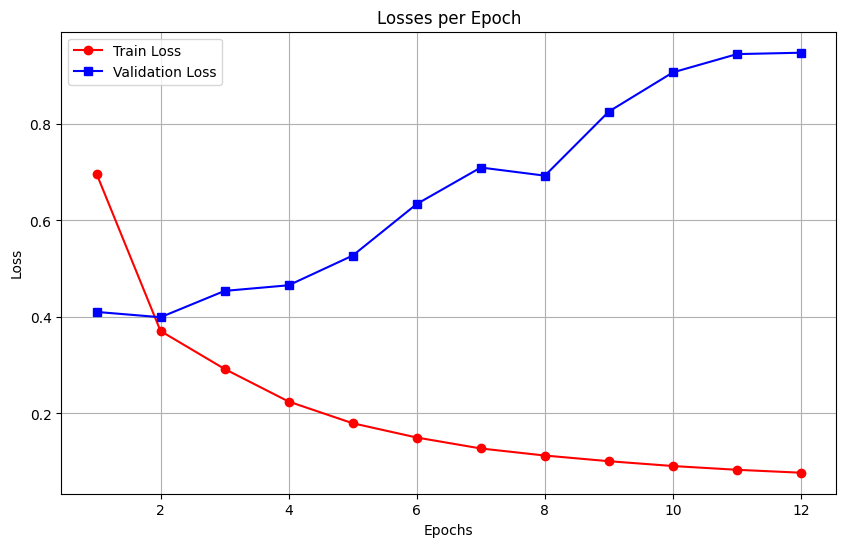

In [29]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss', color="r")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='s', label='Validation Loss', color="b")
plt.title('Losses per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

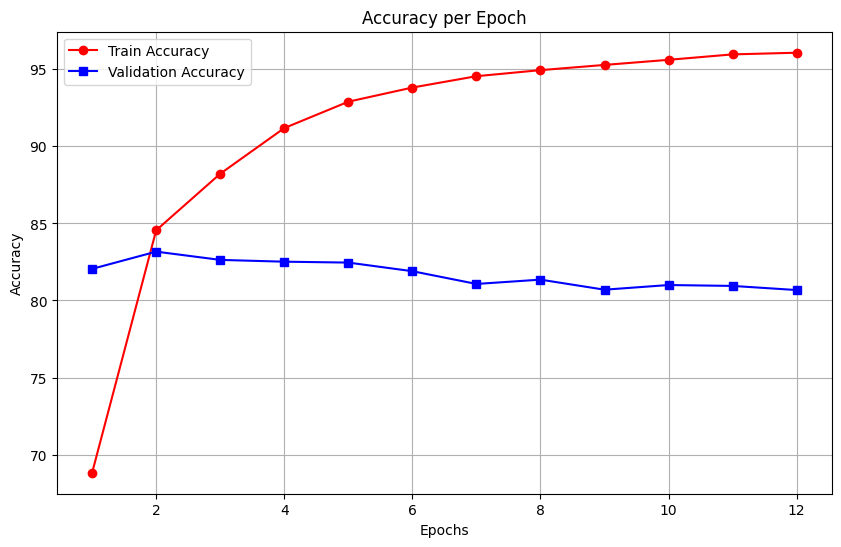

In [30]:
# Plotting Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label='Train Accuracy', color="r")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='s', label='Validation Accuracy', color="b")
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluates the LSTM model on a validation or test set.
def evaluate(model, val_loader, criterion, device):

    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation needed
        for batch in val_loader:
            inputs = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions
            y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true = labels.cpu().numpy()

            all_preds.extend(y_pred)
            all_labels.extend(y_true)

    # Compute average loss
    avg_loss = total_loss / len(val_loader)

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

In [32]:
test_loss, test_acc, test_prec, test_rec, test_f1, all_labels, all_preds = evaluate(model, test_loader, criterion, DEVICE)

Validation Loss: 0.9267
Accuracy: 0.8069
Precision: 0.8051
Recall: 0.8069
F1-score: 0.8056


dict_keys(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity'])


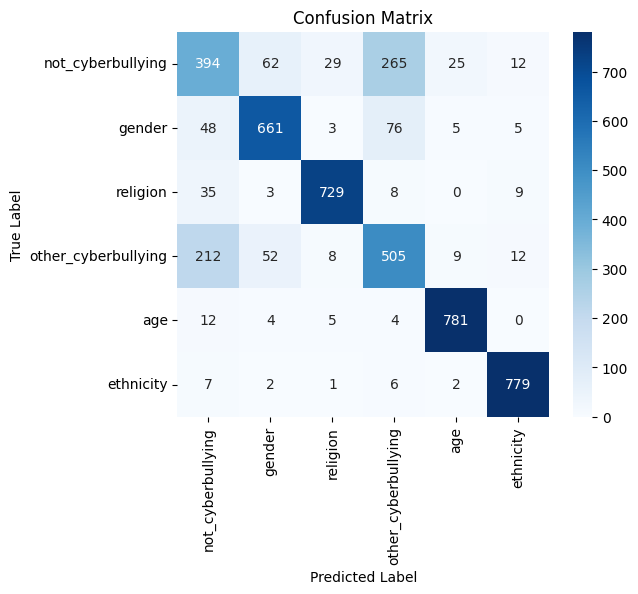

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

print(label_mapping.keys())
# Example usage:
plot_confusion_matrix(all_labels, all_preds, class_names=label_mapping.keys())

In [34]:
n_samples = 10
model.eval()

with torch.no_grad():
    for batch in test_loader:
        inputs = batch["input_ids"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Limit to n_samples
        for i in range(min(n_samples, inputs.size(0))):
            print(f"\nSample {i + 1}")
            print(f"Predicted Label: {preds[i].item()}")
            print(f"Actual Label   : {labels[i].item()}")

        break  # Only evaluate one batch


Sample 1
Predicted Label: 5
Actual Label   : 5

Sample 2
Predicted Label: 1
Actual Label   : 1

Sample 3
Predicted Label: 5
Actual Label   : 5

Sample 4
Predicted Label: 3
Actual Label   : 3

Sample 5
Predicted Label: 0
Actual Label   : 0

Sample 6
Predicted Label: 5
Actual Label   : 5

Sample 7
Predicted Label: 5
Actual Label   : 5

Sample 8
Predicted Label: 1
Actual Label   : 1

Sample 9
Predicted Label: 4
Actual Label   : 4

Sample 10
Predicted Label: 1
Actual Label   : 1
